<a href="https://colab.research.google.com/github/Diego-Hernandez-Jimenez/prototype_learning_LVQ/blob/main/LVQ_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Work in progress...

To do:

* docstrings
* comments and section explanation
* remove redundant code

# Prototype-based learning. Part II: LVQ family of models in Pytorch

This notebook is a continuation of Prototype-based learning. Part I: GMLVQ from scratch. Here all Pytorch features are used to create a more complete model of LVQ. Final implementation allows to:

* use different versions of the LVQ model and of the loss function
* choose among different gradient-based optimization algorithms
* use stochastic or batch gradient descent

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, load_iris, load_digits
from sklearn.model_selection import train_test_split

## Main class and initialization methods

In [16]:
class LVQ(nn.Module):
  """
    A class representing a Learning Vector Quantization (LVQ) model with various modes (GLVQ, GMLVQ, GRLVQ, LGMLVQ, etc.).
    The class supports different prototype initialization strategies and relevance matrices for generalized and local LVQ variants.

    Args:
        lvq_mode (str): The LVQ mode to use. Supported modes include:
        - 'glvq': Generalized LVQ.
        - 'gmlvq': Generalized Matrix LVQ.
        - 'grlvq': Generalized Relevance LVQ.
        - 'lgmlvq': Local Generalized Matrix LVQ.
        - 'lgrlvq': Local Generalized Relevance LVQ.

        data (torch.utils.data.TensorDataset): The dataset used for training, containing feature vectors and class labels.

        n_prototypes_per_class (list): A list where each element indicates the number of prototypes assigned to each class.

        naive_init (bool, optional): Whether to initialize the prototypes randomly (`True`) or based on class averages (`False`).
        Default is `False`.

        activation (torch.nn.Module, optional): The activation function to apply during the forward pass. Default is `nn.Identity()`.

    Attributes:
        W (nn.ParameterList): The list of prototype tensors.
        prototype_labels (torch.Tensor): The class labels associated with each prototype.
        Q (nn.Parameter or nn.ParameterList): The relevance matrix/matrices used to compute distances between inputs and prototypes.
        distance_to_prototypes (callable): The distance function to compute distances between inputs and prototypes.
        activation (torch.nn.Module): The activation function applied to the output of the forward pass.
    """

  def __init__(self, lvq_mode, data, n_prototypes_per_class, naive_init=False, activation=nn.Identity()):
    super(LVQ, self).__init__()
    self.lvq_mode = lvq_mode
    self.n_features = data.tensors[0].shape[1]
    self.n_prototypes = sum(n_prototypes_per_class)
    self.n_prototypes_per_class = n_prototypes_per_class
    self.W, self.prototype_labels = self.init_prototypes(data, naive_init)
    self.Q = self.init_pseudorelevance_matrix()
    self.distance_to_prototypes = self.choose_dist_function()
    self.activation = activation

  def init_prototypes(self, data, naive_init):
    """
    Initializes the prototype vectors. Prototypes can be initialized either randomly (naive) or
    by averaging subsets of data points for each class.

    Args:
        data (torch.utils.data.TensorDataset): The dataset containing feature vectors and class labels.

        naive_init (bool): If `True`, prototypes are initialized randomly around the global average of the dataset.
        If `False`, they are initialized as class averages.

    Returns:
        nn.ParameterList: A list of initialized prototype vectors as parameters.
        torch.Tensor: A tensor containing the class labels associated with each prototype.
    """

    X, y = data.tensors
    W = []
    Wclasses = [[class_id] * times_each_proto for class_id, times_each_proto in enumerate(self.n_prototypes_per_class)]
    Wclasses = sum(Wclasses, []) # flattens nested list
    # Wclasses = []
    if naive_init:
      global_avg = X.mean(dim=0)
      W = [global_avg + torch.randn_like(global_avg) for _ in range(self.n_prototypes)]
    else:
      for class_id, times_each_proto in enumerate(self.n_prototypes_per_class):
        # get prototypes as avg of class
        for _ in range(times_each_proto):
          ids = torch.nonzero(y == class_id).squeeze()
          subset_size = (1/times_each_proto) * len(ids)
          subset_ids = ids[torch.randperm(len(ids))[:int(subset_size)]]
          w = X[subset_ids].mean(dim=0)
          W.append(w)

        # chunk to get prototype associated classes
        # Wclasses.extend([class_id] * times_each_proto)

    return nn.ParameterList(W), torch.tensor(Wclasses).to(device)

  def init_pseudorelevance_matrix(self):
    """
    Initializes the (pseudo)relevance matrix (Q) based on the LVQ mode. In 'gmlvq' and 'grlvq', a global matrix is used, while
    in 'lgmlvq' and 'lgrlvq', local relevance matrices are used for each prototype.

    Returns:
        nn.Parameter or nn.ParameterList: The relevance matrix/matrices depending on the LVQ mode.
    """

    if self.lvq_mode == 'gmlvq':
      Q = torch.sqrt(torch.eye(self.n_features)/self.n_features)
      Q = nn.Parameter(Q)

    elif self.lvq_mode == 'lgmlvq':
      Q = [torch.sqrt(torch.eye(self.n_features)/self.n_features) for _ in range(self.n_prototypes)]
      Q = nn.ParameterList(Q)

    elif self.lvq_mode == 'glvq':
      Q = torch.sqrt(torch.eye(self.n_features))

    elif self.lvq_mode == 'grlvq':
      Q = torch.sqrt(torch.eye(self.n_features))
      Q = nn.Parameter(Q)

    elif self.lvq_mode == 'lgrlvq':
      Q = [torch.sqrt(torch.eye(self.n_features)) for _ in range(self.n_prototypes)]
      Q = nn.ParameterList(Q)

    else:
      print('choose appropiate lvq model')
      return None

    return Q

  def choose_dist_function(self):
    """
    Selects the distance function based on the LVQ mode. The function computes the distance between input
    vectors and the prototypes, using either a global or local relevance matrix.

    Returns:
        callable: A function to compute the distances between input vectors and prototypes.
    """

    dists = []
    if self.lvq_mode == 'gmlvq' or self.lvq_mode == 'glvq' or self.lvq_mode == 'grlvq':
      def distance_to_prototypes(x):
        dists = []
        for j in range(self.n_prototypes):
          raw_diff = x - self.W[j]
          d = torch.linalg.vector_norm(raw_diff @ self.Q, ord=2, dim=1, keepdim=True)**2
          # d = torch.linalg.multi_dot([raw_diff, self.Q.t(), self.Q, raw_diff.t()])
          dists.append(d)
        return torch.cat(dists, dim=1)

    elif self.lvq_mode == 'lgrlvq' or self.lvq_mode == 'lgmlvq':
      def distance_to_prototypes(x):
        dists = []
        for j in range(self.n_prototypes):
          raw_diff = x - self.W[j]
          d = torch.linalg.vector_norm(raw_diff @ self.Q[j], ord=2, dim=1, keepdim=True)**2
          # d = torch.linalg.multi_dot([raw_diff, self.Q[j].t(), self.Q[j], raw_diff.t()])
          dists.append(d)
        return torch.cat(dists, dim=1)
    else:
      print('choose appropiate lvq model')

    return distance_to_prototypes

  def forward(self, x):
    """
     Forward pass for the LVQ model. Computes the distances between the input samples and the prototypes.

     Args:
         x (torch.Tensor): The input data, a tensor of shape (n_samples, n_features).

     Returns:
         torch.Tensor: A tensor containing the distances between each input sample and the prototypes.
    """

    dists = self.distance_to_prototypes(x)
    return dists

# model = LVQ('lgmlvq', data, [1, 2], naive_init=False)

## Loss functions and training procedure

In [17]:
class GLVQLoss(nn.Module):
  """
  Generalized Learning Vector Quantization (GLVQ) loss function, also known as the relative distance loss.
  The loss encourages the distance between input data and correct prototypes (d_pos) to be minimized while
  maximizing the distance to incorrect prototypes (d_neg), using a specified activation function.

  Args:
      activation (torch.nn.Module): The activation function to apply to the computed loss. Common choices are:
      - `torch.nn.Identity()` for linear behavior.
      - `torch.nn.Sigmoid()` for a squashing effect on the relative distances.

  Example:
      >>> loss_fn = GLVQLoss(activation=torch.nn.Sigmoid())
      >>> d_pos = torch.tensor([0.5, 0.2])
      >>> d_neg = torch.tensor([1.0, 0.8])
      >>> loss = loss_fn(d_pos, d_neg)
      >>> print(loss)
  """

  def __init__(self, activation):
    super(GLVQLoss, self).__init__()
    self.activation = activation

  def forward(self, d_pos, d_neg):
    return self.activation((d_pos - d_neg) / (d_pos + d_neg)).mean()

# Other possible loss functions (based on LeCun et al. (2006), hence assuming our LVQ is an energy based model)
# In practice I've notice some weird behavior

class LogLoss(nn.Module):
  def __init__(self):
    super(LogLoss, self).__init__()

  def forward(self, d_pos, d_neg):
    return torch.log(1 + torch.exp(d_pos - d_neg)).mean()

class SquareSquareLoss(nn.Module):
  def __init__(self):
    super(SquareSquareLoss, self).__init__()

  def forward(self, d_pos, d_neg):
    return ( d_pos**2 + torch.relu(1 - d_neg) ).mean()

class SquareExponentialLoss(nn.Module):
  def __init__(self, tau):
    super(SquareExponentialLoss, self).__init__()
    self.tau = tau

  def forward(self, d_pos, d_neg):
    return ( d_pos**2 + self.tau * torch.exp(-d_neg) ).mean()

class HingeLoss(nn.Module):
  def __init__(self):
    super(HingeLoss, self).__init__()

  def forward(self, d_pos, d_neg):
    return torch.relu(1 + d_pos - d_neg).mean()

In [18]:
def train_lvq(model, data_loader, epochs, loss_function, optimizer, scheduler=None, verbose=True):
  """
  Trains a Learning Vector Quantization (LVQ) model over a specified number of epochs using the provided
  data, loss function, and optimization strategy.

  Args:
      model (LVQ): An instance of the LVQ model that is being trained. The model contains prototypes,
      relevance matrices (Q), and the mode of training (e.g., 'gmlvq', 'lgmlvq', etc.).

      data_loader (torch.utils.data.DataLoader): A DataLoader object providing mini-batches of data (features `x`
      and labels `lab`) during training.

      epochs (int): The number of epochs to train the model for.

      loss_function (torch.nn.Module): The loss function to be used during training. Typically, this would be an instance
      of `GLVQLoss`, which computes the relative distance loss.

      optimizer (torch.optim.Optimizer): The optimizer responsible for updating the model parameters (prototypes and
      relevance matrices) based on the computed gradients.

      scheduler (torch.optim.lr_scheduler, optional): A learning rate scheduler that adjusts the learning rate during
      training, if provided. Defaults to `None`.

      verbose (bool, optional): Whether to print loss information after each epoch. If `True`, prints the average loss for each epoch.
      Defaults to `True`.

  Returns:
      None: The function updates the model parameters in place and prints loss information during training.

  Training Procedure:
      - For each mini-batch of data:
          1. Compute the distances between the input samples and the prototypes using the model.
          2. Identify the closest correct prototype (`d_pos`) and the closest incorrect prototype (`d_neg`) for each sample.
          3. Compute the loss using the provided `loss_function` (e.g., GLVQ loss).
          4. Perform backpropagation to compute the gradients.
          5. Update the model parameters (prototypes and relevance matrices) using the `optimizer`.
          6. If a `scheduler` is provided, adjust the learning rate after each step.
          7. Normalize the relevance matrices (`Q`) after each update to maintain their constraints.
      - After each epoch, print the average loss if `verbose` is set to `True`.

  Example:
      >>> model = LVQ('gmlvq', data, n_prototypes_per_class)
      >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
      >>> loss_fn = GLVQLoss(torch.nn.Identity())
      >>> train_lvq(model, data_loader, epochs=100, loss_function=loss_fn, optimizer=optimizer)

  Notes:
      - Different normalization steps are applied to the relevance matrix `Q` depending on the chosen LVQ mode:
          - 'gmlvq' and 'grlvq': Normalizes `Q` globally.
          - 'lgmlvq' and 'lgrlvq': Normalizes each relevance matrix individually.
  """

  model.train()
  for epoch in range(epochs):
    total_loss = 0.0
    for x, lab in data_loader:
      x, lab = x.to(device), lab#.to(device)
      optimizer.zero_grad()

      dists = model(x)
      d_pos = torch.stack([torch.min(dists[i, model.prototype_labels == lab[i]]) for i in range(len(lab))])
      d_neg = torch.stack([torch.min(dists[i, model.prototype_labels != lab[i]]) for i in range(len(lab))])

      loss = loss_function(d_pos, d_neg)
      total_loss += loss.item()
      loss.backward()
      optimizer.step()
      if scheduler is not None:
        scheduler.step()

      with torch.no_grad():
        if model.lvq_mode == 'gmlvq':
          model.Q.data = model.Q / torch.sqrt((model.Q.T @ model.Q).diag().sum())

        elif model.lvq_mode == 'grlvq':
          model.Q.data = torch.diag(torch.diag(model.Q.data))
          model.Q.data = model.Q / torch.sqrt((model.Q.T @ model.Q).diag().sum())

        elif model.lvq_mode == 'lgrlvq':
          for j in range(len(model.Q)):
            model.Q[j].data = torch.diag(torch.diag(model.Q[j].data))
            model.Q[j].data = model.Q[j] / torch.sqrt((model.Q[j].T @ model.Q[j]).diag().sum())

        elif model.lvq_mode == 'lgmlvq':
          for j in range(len(model.Q)):
            model.Q[j].data = model.Q[j] / torch.sqrt((model.Q[j].T @ model.Q[j]).diag().sum())

        else:
          pass

    if verbose:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(data_loader)}")

  return None

def predict_class(X, model):
  """
  Predicts the class labels for a set of input samples based on the nearest prototype
  in the provided LVQ model.

  Args:
      X (torch.Tensor): A tensor of shape (n_samples, n_features) containing the input data for which
      class predictions are required.

      model (LVQ): An instance of the trained LVQ model, containing the learned prototypes and relevance
      matrices. The model is used to compute the distances between the input samples and the prototypes.

  Returns:
      torch.Tensor: A tensor of shape (n_samples,) containing the predicted class labels for each input sample.
      The predicted label corresponds to the class of the prototype closest to each sample.

  Example:
      >>> X_test = torch.randn(100, n_features)
      >>> model = trained_lvq_model
      >>> preds = predict_class(X_test, model)

  Notes:
      - The function operates in evaluation mode, ensuring that gradients are not computed (via `torch.no_grad()`).
      - For each input sample, it computes the distances to all prototypes using the LVQ model, and selects
        the class label of the closest prototype.
  """

  preds = torch.zeros(X.shape[0])
  with torch.no_grad():
    for i in range(X.shape[0]):
      x = X[i].unsqueeze(0)
      d = model(x)
      preds[i] = model.prototype_labels[torch.argmin(d)]

  return preds

## Test 1: replicating [Schneider et al. (2009)](https://www.cs.rug.nl/~biehl/Preprints/gmlvq.pdf)

If we've implemented the model correctly, we would be able to reproduce the results we obtained in the first notebook. But not only that, our PyTorch module is more flexible now and we are theoretically capable of replicating concerning the results of every LVQ model compared in the paper.

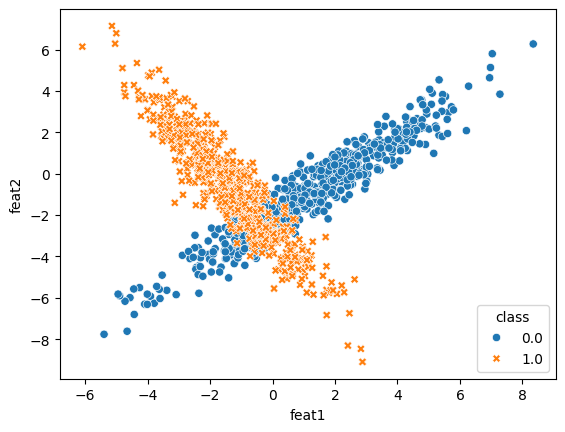

In [19]:
def create_artificial_data(n:int, seed:int) -> tuple:
  """
  The dataset consists of two clusters of data points,
    each generated from a different multivariate normal distribution with specific
    means, covariance matrices, and rotations (inspired by Schneider et al., 2009).

    Args:
        n (int): Number of samples to generate for each cluster.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: A tuple containing:
            - data (torch.utils.data.TensorDataset): A PyTorch TensorDataset containing
              the features and labels.
            - df (pandas.DataFrame): A pandas DataFrame containing the features and labels,
              where 'feat1' and 'feat2' are the feature columns and 'class' is the label column.

    Details:
        - Two clusters are generated from multivariate normal distributions with means
          [1.5, 0.0] and [-1.5, 0.0], and covariance matrices with diagonal values
          [0.5^2, 3.0^2].
        - The first cluster is rotated by pi/4 radians, and the second cluster by -pi/6 radians.
        - The final dataset is a combination of both clusters, with labels 0 for the first
          cluster and 1 for the second.

    Example:
        data, df = create_artificial_data(n=100, seed=42)
  """

  torch.manual_seed(seed)
  MV0 = torch.distributions.MultivariateNormal(
      loc=torch.tensor([1.5, 0.0]),
      covariance_matrix=torch.diag(torch.tensor([0.5, 3.0])).pow(2) # [0.1,3.0] [0.5,3.0]
  )
  MV1 = torch.distributions.MultivariateNormal(
      loc=torch.tensor([-1.5, 0.0]), # [-0.8,0.0]
      covariance_matrix=torch.diag(torch.tensor([0.5, 3.0])).pow(2) # [0.1,3.0] [0.5,3.0]
  )
  cluster0 = MV0.sample((1, n)).squeeze(0)
  cluster1 = MV1.sample((1, n)).squeeze(0)

  phi = torch.tensor([torch.pi/4, -torch.pi/6])
  rot_matrix0 = torch.tensor(
      [[torch.cos(phi[0]), -torch.sin(phi[0])],
      [torch.sin(phi[0]), torch.cos(phi[0])]]
  )
  rot_matrix1 = torch.tensor(
      [[torch.cos(phi[1]), -torch.sin(phi[1])],
      [torch.sin(phi[1]), torch.cos(phi[1])]]
  )
  X0 = torch.matmul(cluster0, rot_matrix0)
  X1 = torch.matmul(cluster1, rot_matrix1)
  X = torch.cat([X0, X1], dim=0)
  y = torch.cat([torch.zeros(n), torch.ones(n)])

  # tensor dataset
  data = torch.utils.data.TensorDataset(X, y)

  # pandas dataframe
  df = pd.DataFrame(X, columns=['feat1', 'feat2'])
  df['class'] = y

  return data, df

n = 600
data, df = create_artificial_data(n, seed=42)
p = sns.scatterplot(data=df, x="feat1", y="feat2", hue="class", style="class")

In [20]:
# small batch size seems to always work better (not only in this first example)
dl = DataLoader(data, batch_size=5, shuffle=True)

# technically, the module allows the use of GPU, but I believe the type of
# some of operations involved (e.g. argmins) pervents us from increasing performance

device = 'cpu'

loss_function = GLVQLoss(nn.Identity())

########################################## Generalized LVQ (new!)
model_glvq = LVQ('glvq', data, [1, 1])
optim_glvq = torch.optim.SGD(model_glvq.W, lr=0.01)
train_lvq(model_glvq, dl, 10, loss_function, optim_glvq, scheduler=None, verbose=False)
##########################################

########################################## Generalized LVQ with 2 prototypes (new!)
model_glvq2 = LVQ('glvq', data, [2, 2])
optim_glvq2 = torch.optim.SGD(model_glvq.W, lr=0.01)
train_lvq(model_glvq2, dl, 10, loss_function, optim_glvq2, scheduler=None, verbose=False)
##########################################


########################################## Generalized Relevance LVQ (new!)
model_grlvq = LVQ('grlvq', data, [1, 1])
optim_grlvq = torch.optim.SGD([
      {'params': model_grlvq.W, 'lr': 0.01},
      {'params': model_grlvq.Q, 'lr': 0.01}
])
train_lvq(model_grlvq, dl, 10, loss_function, optim_grlvq, scheduler=None, verbose=False)
##########################################


######################################### Generalized Matrix LVQ
model_gmlvq = LVQ('gmlvq', data, [1, 1])
optim_gmlvq = torch.optim.SGD([
      {'params': model_gmlvq.W, 'lr': 0.01},
      {'params': model_gmlvq.Q, 'lr': 0.01}
])
train_lvq(model_gmlvq, dl, 10, loss_function, optim_gmlvq, scheduler=None, verbose=False)
##########################################


########################################## Localized Generalized Relevance LVQ (new!)
model_lgrlvq = LVQ('lgrlvq', data, [1, 1])
optim_lgrlvq = torch.optim.SGD([
      {'params': model_lgrlvq.W, 'lr': 0.01},
      {'params': model_lgrlvq.Q, 'lr': 0.01}
])
train_lvq(model_lgrlvq, dl, 10, loss_function, optim_lgrlvq, scheduler=None, verbose=False)
##########################################


########################################## Localized Generalized Matrix LVQ
model_lgmlvq = LVQ('lgmlvq', data, [1, 1])
optim_lgmlvq = torch.optim.SGD([
      {'params': model_lgmlvq.W, 'lr': 0.01},
      {'params': model_lgmlvq.Q, 'lr': 0.01}
])
train_lvq(model_lgmlvq, dl, 10, loss_function, optim_lgmlvq, scheduler=None, verbose=False)
##########################################


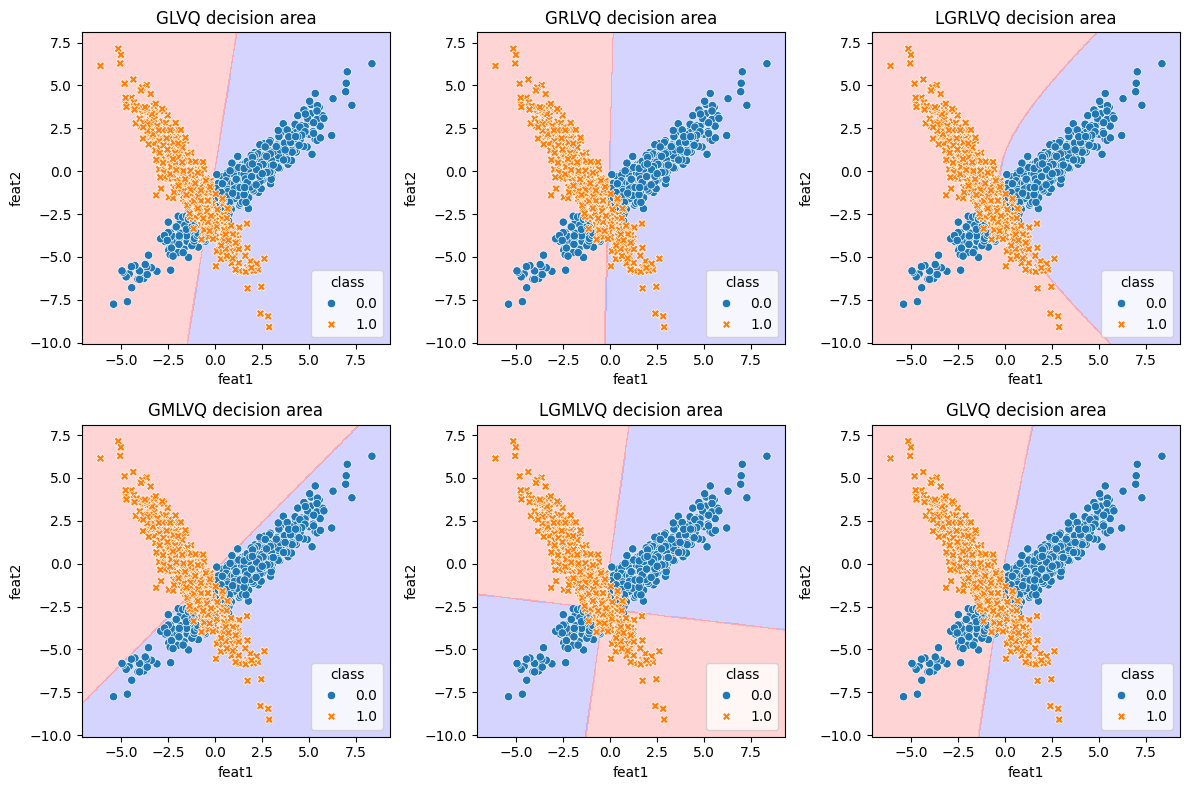

In [24]:
def data_for_decision_area(model, df):
    """
    Generates grid data for visualizing the decision boundaries of an LVQ model.

    Args:
        model (LVQ): Trained LVQ model used to predict class labels on the grid.
        df (pd.DataFrame): DataFrame containing the features 'feat1' and 'feat2' for plotting the feature space.

    Returns:
        tuple: xx, yy meshgrid tensors and Z tensor of predicted class labels for each grid point.

    Example:
        >>> xx, yy, Z = data_for_decision_area(trained_model, df)
    """
    # Define plot boundaries
    x_min, x_max = df['feat1'].min() - 1, df['feat1'].max() + 1
    y_min, y_max = df['feat2'].min() - 1, df['feat2'].max() + 1

    # Generate grid of points with indexing="xy" to avoid the warning
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.05),
                            torch.arange(y_min, y_max, 0.05), indexing="xy")

    # Prepare grid tensor and predict class for each point
    grid_tensor = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    predicted_classes = predict_class(grid_tensor, model)

    # Reshape predictions for plotting
    Z = predicted_classes.reshape(xx.shape)

    return xx, yy, Z



# Model list to iterate
models = [model_glvq, model_grlvq, model_lgrlvq, model_gmlvq, model_lgmlvq, model_glvq2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Iterate over models and create plots
for i, model in enumerate(models):
    xx, yy, Z = data_for_decision_area(model, df)
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['#AAAAFF', '#FFAAAA']))
    sns.scatterplot(data=df, x='feat1', y='feat2', hue='class', style='class', ax=ax)
    ax.set_xlabel('feat1')
    ax.set_ylabel('feat2')
    ax.set_title(f'{model.lvq_mode.upper()} decision area')

# fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('all_models_decision_area.png', dpi=300)
plt.show()

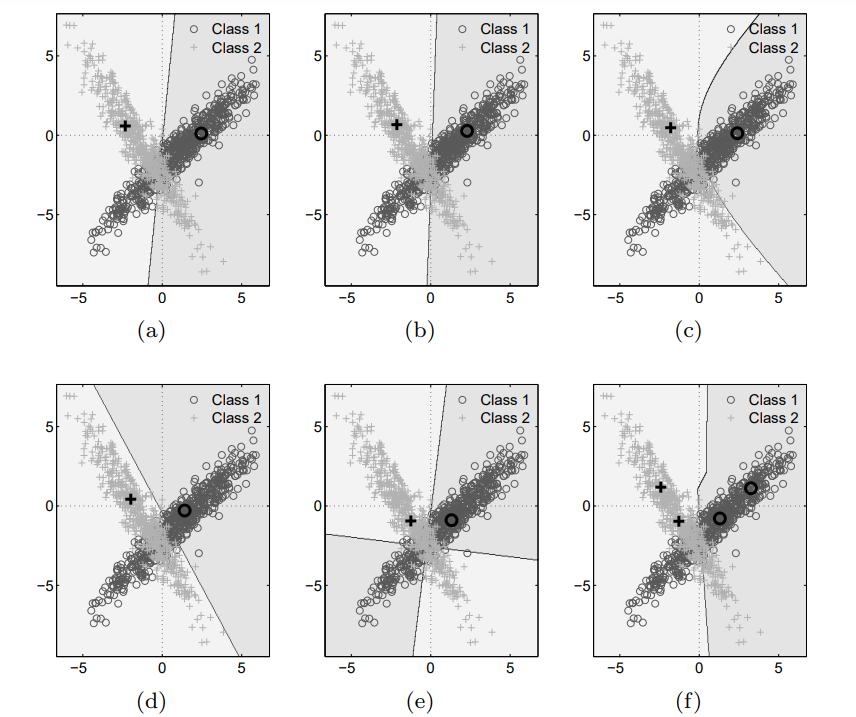

a) GLVQ

b) GRLVQ

c) LGRLVQ

d) GMLVQ

e) LGMLVQ

f) GLVQ using two prototypes per class

In [ ]:
# if we wanted to get specific accuracies (although it's easy to see which model is better)

# X, y = data.tensors
# preds = predict_class(X, model)
# (y == preds).float().mean()

## Test 2: Breast cancer dataset

Will the model work with real data?

In [ ]:
cancer_data = load_breast_cancer()
# data = TensorDataset(torch.from_numpy(cancer_data.data).float(), torch.from_numpy(cancer_data.target))
# load the data
cancer_data = load_breast_cancer()
X = torch.from_numpy(cancer_data.data).float()
y = torch.from_numpy(cancer_data.target)

# split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = TensorDataset(Xtest, ytest)
test_dl = DataLoader(test_data, batch_size=16, shuffle=False)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

model = LVQ('gmlvq', train_data, [1, 1])
loss_function = GLVQLoss(nn.ReLU()) # instead of the identity, we are now using ReLU
optimizer = torch.optim.SGD([
      {'params': model.W, 'lr': 0.01},
      {'params': model.Q, 'lr': 0.01}
  ])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_lvq(model, train_dl, 20, loss_function, optimizer, scheduler)
preds = predict_class(Xtest, model)
(ytest == preds).float().mean()

Training data size: torch.Size([455, 30])
Test data size: 114
Epoch 1/20, Loss: 0.06982578178225406
Epoch 2/20, Loss: 0.06830167349684856
Epoch 3/20, Loss: 0.06830152676537118
Epoch 4/20, Loss: 0.07040461803112051
Epoch 5/20, Loss: 0.07001338191009288
Epoch 6/20, Loss: 0.07103995464196236
Epoch 7/20, Loss: 0.07129680435976078
Epoch 8/20, Loss: 0.07136693519764933
Epoch 9/20, Loss: 0.06830152743977719
Epoch 10/20, Loss: 0.07101267564174688
Epoch 11/20, Loss: 0.06830152686171491
Epoch 12/20, Loss: 0.07099504800962991
Epoch 13/20, Loss: 0.0683015261311084
Epoch 14/20, Loss: 0.06830152564136119
Epoch 15/20, Loss: 0.06955808200391717
Epoch 16/20, Loss: 0.0683015260187074
Epoch 17/20, Loss: 0.06830152737554805
Epoch 18/20, Loss: 0.07070680807248272
Epoch 19/20, Loss: 0.07080716792301371
Epoch 20/20, Loss: 0.0683015266369129


tensor(0.9386)

## Test 3: Iris dataset

Will the model work well with more than 2 classes?

In [ ]:
iris_data = load_iris()
X = torch.from_numpy(iris_data.data).float()
y = torch.from_numpy(iris_data.target)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = TensorDataset(Xtest, ytest)
test_dl = DataLoader(test_data, batch_size=16, shuffle=False)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

model = LVQ('glvq', train_data, [1, 1, 1]) # here is the little change to incorporate more than two classes
loss_function = GLVQLoss(nn.Identity())
optimizer = torch.optim.SGD(model.W, lr=0.01)
train_lvq(model, train_dl, 10, loss_function, optimizer)

preds = predict_class(Xtest, model)
(ytest == preds).float().mean()

Training data size: torch.Size([120, 4])
Test data size: 30
Epoch 1/10, Loss: -0.703588955104351
Epoch 2/10, Loss: -0.7180484086275101
Epoch 3/10, Loss: -0.7080054730176926
Epoch 4/10, Loss: -0.7166101709008217
Epoch 5/10, Loss: -0.7029648125171661
Epoch 6/10, Loss: -0.7203597500920296
Epoch 7/10, Loss: -0.721857413649559
Epoch 8/10, Loss: -0.7185317575931549
Epoch 9/10, Loss: -0.7151784896850586
Epoch 10/10, Loss: -0.6988477073609829


tensor(0.9667)

## Test 4: Apple quality dataset

This is one example where prototype learning can be specially helpful

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/LVQ

/content/drive/MyDrive/Colab_Notebooks/LVQ


In [ ]:
df = pd.read_csv('apple_quality.csv', skipfooter=1)
df.drop(columns=['A_id'], inplace=True) # remove identifier
df['Quality_ohe'] = (df['Quality'] == 'good').astype(float) # one hot encoding

Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop(['Quality', 'Quality_ohe'], axis=1), df['Quality_ohe'], test_size=0.2)

Xtrain = torch.from_numpy(Xtrain.values).float()
ytrain = torch.from_numpy(ytrain.values)
train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)

Xtest = torch.from_numpy(Xtest.values).float()
ytest = torch.from_numpy(ytest.values)
test_data = TensorDataset(Xtest, ytest)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

model = LVQ('lgmlvq', train_data, [1, 1])
loss_function = GLVQLoss(nn.Sigmoid())

# check this out, we are not forced to always use vanilla gradient descent!
optimizer = torch.optim.RMSprop([
    {'params': model.W, 'lr': 0.005},
    {'params': model.Q, 'lr': 0.001}
])
train_lvq(model, train_dl, 50, loss_function, optimizer)

preds = predict_class(Xtest, model)
(ytest == preds).float().mean()

<ipython-input-40-f06983c41024>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('apple_quality.csv', skipfooter=1)


Training data size: torch.Size([3200, 7])
Test data size: 800
Epoch 1/50, Loss: 0.40435783460736274
Epoch 2/50, Loss: 0.3846436233073473
Epoch 3/50, Loss: 0.381255764067173
Epoch 4/50, Loss: 0.3799774472415447
Epoch 5/50, Loss: 0.3796311032027006
Epoch 6/50, Loss: 0.3794853616505861
Epoch 7/50, Loss: 0.3794095546007156
Epoch 8/50, Loss: 0.3793111342191696
Epoch 9/50, Loss: 0.3795410530269146
Epoch 10/50, Loss: 0.3795793736726046
Epoch 11/50, Loss: 0.37953842923045156
Epoch 12/50, Loss: 0.3794828153401613
Epoch 13/50, Loss: 0.3793472997099161
Epoch 14/50, Loss: 0.37953036904335025
Epoch 15/50, Loss: 0.3794270756840706
Epoch 16/50, Loss: 0.3793985564261675
Epoch 17/50, Loss: 0.37938021287322043
Epoch 18/50, Loss: 0.37942192479968073
Epoch 19/50, Loss: 0.3794295444339514
Epoch 20/50, Loss: 0.379437108039856
Epoch 21/50, Loss: 0.3795415708422661
Epoch 22/50, Loss: 0.379161222204566
Epoch 23/50, Loss: 0.37954827390611173
Epoch 24/50, Loss: 0.3793265801668167
Epoch 25/50, Loss: 0.37937558092

tensor(0.8400)

## Test 5: digits dataset (8 × 8 images)

How does the model work with images? Do we get useful prototypes?

In [ ]:
digits_data = load_digits()

X = torch.from_numpy(digits_data.data).float()
y = torch.from_numpy(digits_data.target)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)
test_data = TensorDataset(Xtest, ytest)
test_dl = DataLoader(test_data, batch_size=8, shuffle=False)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

device = 'cpu'
prototypes_per_class = [1]*y.unique().numel()
# prototypes_per_class = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2]

# we choose plain glvq because prototypes are more "understandable", as
# you will see later.
# we also force a naive initialization (prototypes are initialized as the global mean + normal noise)
# instead of using class means to see the evolution in the prototypes
model = LVQ('glvq', train_data, prototypes_per_class, naive_init=True)
loss_function = GLVQLoss(nn.Sigmoid())

# we are getting the initial prototypes for visualization purposes (see later)
initial_W = [model.W[i].detach().clone() for i in range(len(model.W))]
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_lvq(model, train_dl, 50, loss_function, optimizer, scheduler=None, verbose=False)

preds = predict_class(Xtest, model)
(ytest == preds).float().mean()

Training data size: torch.Size([1437, 64])
Test data size: 360


tensor(0.9417)

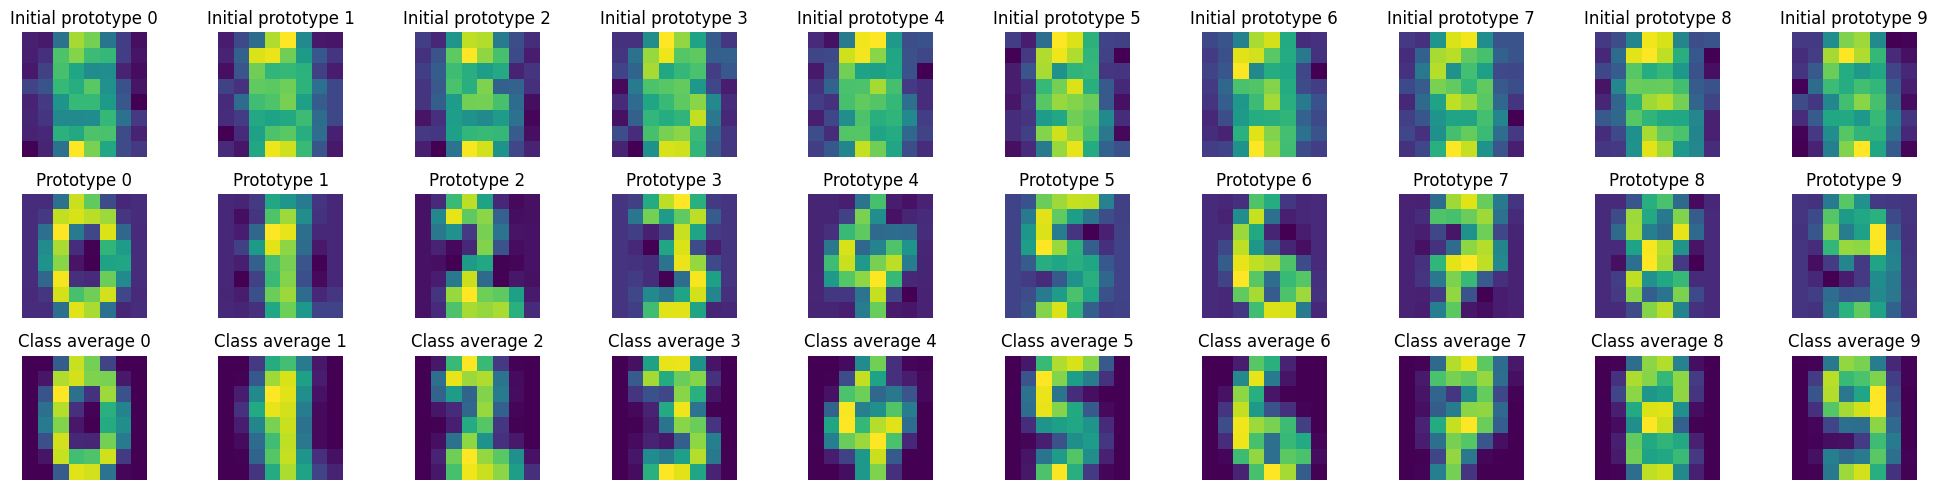

In [ ]:
def plot_img_prototypes(model, X, y, img_size, out_name):
  """
  Plots and saves the initial prototypes, learned prototypes, and real class averages
  as images for each class after training.

  Args:
      model (LVQ): Trained LVQ model containing learned prototypes.
      X (torch.Tensor): Input data (images), tensor of shape (n_samples, n_features).
      y (torch.Tensor): Labels associated with the input data, tensor of shape (n_samples).
      img_size (int): Size of the square images (height and width).
      out_name (str): Name of the output file to save the plot (without extension).

  Returns:
      None: The function saves a PNG file with the plot and displays it.

  Example:
      >>> plot_img_prototypes(trained_model, X, y, 28, 'prototypes_plot')

  Functionality:
  - First row: Displays the initial prototypes (before learning).
  - Second row: Displays the learned prototypes (after training).
  - Third row: Displays the real average images of each class from the dataset.
  - The function outputs a `.png` file with the generated plots.
  """

  p = model.n_prototypes
  fig, axes = plt.subplots(3, p, figsize=(20, 5))

  for i in range(p):

      initial_prototype = initial_W[i].reshape(img_size, img_size).numpy()
      ax0 = axes[0, i]
      ax0.imshow(initial_prototype) # , cmap='gray'
      ax0.axis('off')
      ax0.set_title(f'Initial prototype {i}')

      # prototype after learning
      prototype = model.W[i].detach().reshape(img_size, img_size).numpy()
      ax1 = axes[1, i]
      ax1.imshow(prototype) # , cmap='gray'
      ax1.axis('off')
      ax1.set_title(f'Prototype {i}')

      # Compute and show real average of each class
      real_avg = X[y == i].mean(dim=0).reshape(img_size, img_size).numpy()
      ax2 = axes[2, i]
      ax2.imshow(real_avg) # , cmap='gray'
      ax2.axis('off')
      ax2.set_title(f'Class average {i}')

  plt.tight_layout()
  plt.savefig(f'{out_name}.png', dpi=300, bbox_inches='tight')
  plt.show()

  return None

plot_img_prototypes(model, X, y, 8, 'lvq_digits')

Test 6: MNIST dataset

Will the model work with high dimensional data?

In [ ]:
digits_train = MNIST(root='./data', train=True, download=True, transform=None)
Xtrain = digits_train.data.flatten(start_dim=1, end_dim=2).float()
ytrain = digits_train.targets
train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=16, shuffle=True)

digits_test = MNIST(root='./data', train=False, download=True, transform=None)
Xtest = digits_test.data.flatten(start_dim=1, end_dim=2).float()
ytest = digits_test.targets
test_data = TensorDataset(Xtrain, ytrain)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

device = 'cpu'
prototypes_per_class = [1]*y.unique().numel()
model = LVQ('glvq', train_data, prototypes_per_class, naive_init=True)
loss_function = GLVQLoss(nn.ReLU())
initial_W = [model.W[i].detach().clone() for i in range(len(model.W))]

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_lvq(model, train_dl, 100, loss_function, optimizer, scheduler=None, verbose=False)

preds = predict_class(Xtest, model)
(ytest == preds).float().mean()

Training data size: torch.Size([60000, 784])
Test data size: 10000


tensor(0.8914)

In [ ]:
# torch.save(model.state_dict(), 'mnist_model_params.pth')
# torch.save(model.state_dict(), 'mnist_model.pth')

model = LVQ('glvq', train_data, prototypes_per_class, naive_init=True)
initial_W = [model.W[i].detach().clone() for i in range(len(model.W))]
params = torch.load('mnist_model_params.pth')
model.load_state_dict(params)

<ipython-input-77-be4f2ce77311>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load('mnist_model_params.pth')


<All keys matched successfully>

In [ ]:
X = torch.cat([Xtrain, Xtest], dim=0)
y = torch.cat([ytrain, ytest], dim=0)

# plot_img_prototypes(model, X, y, 28, 'lvq_mnist')